# Neural Network (MLP) Model



Dieses Notizbuch verwendet einen ähnlichen Ansatz wie das Notizbuch "MLP_mit_Log". Es beinhaltet das Entwerfen, Trainieren und Evaluieren eines neuronalen Netzwerkmodells mit mehreren Schichten. Die Variablen werden durch einen robusten Skalierer skaliert, der Ausreißer effektiv behandeln kann. Es deckt die praktischen Aspekte der Modellentwicklung in PyTorch ab, von der Einrichtung der Umgebung bis hin zum Training und der Bewertung des Modells unter Verwendung von RMSE. Im Vergleich zum neuronalen Netzwerk mit Logarithmustransformation erbringt das neuronale Netzwerk mit robustem Skalierer bessere Leistungen mit einem niedrigeren RMSE.

In [ ]:
# import standard python libraries
from datetime import datetime
import numpy as np
import pandas as pd

# import the PyTorch deep learning libary
import torch, torchvision
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Gestalten eines Neuronalen Netzwerks

In [ ]:
# implement  MLP Network Architecture


class Cars(nn.Module):

  def __init__(self):

        super(Cars, self).__init__()

        # specify fully-connected (fc) layer 1 - 14 feautres
        self.linear1 = nn.Linear(643, 1286, bias=True) # the linearity W*x+b

        # specify fc layer 2 -
        self.linear2 = nn.Linear(1286, 832, bias=True) # the linearity W*x+b

        # specify fc layer 3 -
        self.linear3 = nn.Linear(832, 416, bias=True) # the linearity W*x+b

        # specify fc layer 4 -
        self.linear4 = nn.Linear(416, 208, bias=True) # the linearity W*x+b

        # specify fc layer 5 -
        self.linear5 = nn.Linear(208, 104, bias=True) # the linearity W*x+b

        # specify fc layer 6 -
        self.linear6 = nn.Linear(104, 30, bias=True) # the linearity W*x+b

        # specify fc layer 7
        self.linear7 = nn.Linear(30, 1) # the linearity W*x+b

        # relu non-linear activation function
        self.relu = nn.ReLU(inplace=True)

        # Dropout-Schichten
        self.dropout1 = nn.Dropout(p=0.3) # Dropout mit einer Wahrscheinlichkeit von 50%
        self.dropout2 = nn.Dropout(p=0.1) # Sie können die Wahrscheinlichkeit anpassen

  def forward(self, samples):
        x = samples

        x = self.relu(self.linear1(x))
        x = self.dropout1(x) # Dropout nach der ersten Schicht

        x = self.relu(self.linear2(x))
        x = self.dropout1(x) # Wiederholung des Dropout

        x = self.relu(self.linear3(x))
        x = self.dropout2(x) # Verwendung des zweiten Dropout

        x = self.relu(self.linear4(x))
        # Kein Dropout nach jeder Schicht erforderlich

        x = self.relu(self.linear5(x))
        x = self.relu(self.linear6(x))
        x = self.linear7(x)

        return x

In [ ]:
model = Cars()

In [ ]:
# init the number of model parameters
num_params = 0

# iterate over the distinct parameters
for param in model.parameters():

    # collect number of parameters
    num_params += param.numel()

print('Architecture:\n\n{}\n'.format(model))
print("Model parameters: {}.".format(num_params))

Architecture:

Cars(
  (linear1): Linear(in_features=643, out_features=1286, bias=True)
  (linear2): Linear(in_features=1286, out_features=832, bias=True)
  (linear3): Linear(in_features=832, out_features=416, bias=True)
  (linear4): Linear(in_features=416, out_features=208, bias=True)
  (linear5): Linear(in_features=208, out_features=104, bias=True)
  (linear6): Linear(in_features=104, out_features=30, bias=True)
  (linear7): Linear(in_features=30, out_features=1, bias=True)
  (relu): ReLU(inplace=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

Model parameters: 2357149.


In [ ]:
pd.set_option('display.max_columns', None)

# Read in the data
cars = pd.read_csv("Cars_Data_Model.csv", sep=";", index_col=0)
cars = cars.copy()

In [ ]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70373 entries, 0 to 70372
Columns: 644 entries, Preis to Taxi oder Mietwagen_Nein
dtypes: float64(5), int64(639)
memory usage: 346.3 MB


In [ ]:
# Behalte nur Samples mit einem Preis kleiner als 300,000 --> Ausreisser entfernen
cars = cars[cars["Preis"] < 300000]

In [ ]:
# Quelle: ChatGPT (Hilfe bei Umformungen)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# Define X and y and drop features
X = cars.drop("Preis", axis=1)
y = cars.loc[:,"Preis"]


# Define Train Test Eval
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)


# Data Scaling
scaler = RobustScaler()
scaler.fit(X_train)

# Scale the three datasets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)




# Training Data

# Convert in NumPy arrays
numpy_X_train = X_train
numpy_y_train = y_train.values

# Convert NumPy arrays to PyTorch tensors
tensor_X_train = torch.from_numpy(numpy_X_train).float()
tensor_y_train = torch.from_numpy(numpy_y_train).float()

# Create a TensorDataset
dataset_train = TensorDataset(tensor_X_train, tensor_y_train)



# Validation Data

# Convert in NumPy arrays
numpy_X_val = X_val
numpy_y_val = y_val.values

# Convert NumPy arrays to PyTorch tensors
tensor_X_val = torch.from_numpy(numpy_X_val).float()
tensor_y_val = torch.from_numpy(numpy_y_val).float()

# Create a TensorDataset
dataset_val = TensorDataset(tensor_X_val, tensor_y_val)


# Test Data

# Convert in NumPy arrays
numpy_X_test = X_test
numpy_y_test = y_test.values

# Convert NumPy arrays to PyTorch tensors
tensor_X_test = torch.from_numpy(numpy_X_test).float()
tensor_y_test = torch.from_numpy(numpy_y_test).float()

# Create a TensorDataset
dataset_test = TensorDataset(tensor_X_test, tensor_y_test)

In [ ]:
# Quelle ChatGPT

# Define the loss function for regression

class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()

    def forward(self, input, target):
        loss = torch.sqrt(torch.mean((input - target)**2))
        return loss

## Trainieren des Neuronalen Netzwerkes

In [ ]:
# define hyperparameter to start our whole training process
from torch.optim.lr_scheduler import StepLR

num_epoch = 500 # number of training epochs
batch_size = 16 # size of the mini-batches
learning_rate = [0.001] # stepsize that is used for the modifications of the weight parameters


# define dataloaders
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size= len(X_val), shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size= len(X_test), shuffle=True)




# Init collection of training epoch losses
train_epochs_loss = []

# Init collection of validation epoch losses
val_epochs_loss = []


for rate in learning_rate:

  print(f"Learning Rate: {rate}")

  # model setup
  model = Cars()
  model = model.to(device)
  optimizer = optim.Adam(model.parameters(), lr=rate)
  #scheduler = StepLR(optimizer, step_size=30, gamma=0.5)

  loss_function = RMSELoss()
  #loss_function = nn.MSELoss()
  loss_function = loss_function.to(device)

  # define optimization strategy
  #optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)
  optimizer = optim.Adam(params=model.parameters(), lr=rate)

  # Train the model
  for epoch in range(num_epoch):

    # Set the model in training mode
    model.train()

    # Init collection of mini-batch losses
    train_mini_batch_losses = []

    # Iterate over all mini-batches
    for features, labels in train_dataloader:
        # Push mini-batch data to computation device
        features = features.float().to(device)
        labels = labels.view(-1, 1).float().to(device)

        # Run forward pass through the network
        output = model.forward(features)



        # Reset graph gradients
        model.zero_grad()

        # Determine regression loss
        loss = loss_function(output, labels)


        # Run backward pass, Backpropagation (computes the gradients)
        loss.backward()

        # Update network parameters in order to reduce loss
        optimizer.step()

        # Collect mini-batch reconstruction loss
        train_mini_batch_losses.append(loss.item())

    # Determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)
    train_epochs_loss.append(train_epoch_loss)

    # Set the model in eval mode
    model.eval()

    # Init collection of all epoch loss
    val_epoch_loss = 0

    # Iterate over one validation batch
    for features, labels in val_dataloader:
        # Push validation data to computation device
        features = features.float().to(device)
        labels = labels.view(-1, 1).float().to(device)


        # Run forward pass through the network
        output = model.forward(features)

        # Determine regression loss
        loss = loss_function(output, labels)

        # Collect validation reconstruction loss
        val_epoch_loss = loss.item()

    # Save the loss of this epoch
    val_epochs_loss.append(val_epoch_loss)

    # Print epoch lossw
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[{}] Epoch: {} Train loss: {}'.format(str(now), str(epoch + 1), str(train_epoch_loss)))
    print('[{}] Epoch: {} Validation loss: {}'.format(str(now), str(epoch + 1), str(val_epoch_loss)))


Learning Rate: 0.001
[20231215-17:57:53] Epoch: 1 Train loss: 23596.27511600648
[20231215-17:57:53] Epoch: 1 Validation loss: 18678.388671875
[20231215-17:58:04] Epoch: 2 Train loss: 17301.67971051716
[20231215-17:58:04] Epoch: 2 Validation loss: 17155.79296875
[20231215-17:58:16] Epoch: 3 Train loss: 15705.717390400225
[20231215-17:58:16] Epoch: 3 Validation loss: 16726.34765625
[20231215-17:58:27] Epoch: 4 Train loss: 14325.148345510734
[20231215-17:58:27] Epoch: 4 Validation loss: 17002.4375
[20231215-17:58:39] Epoch: 5 Train loss: 13668.265543170031
[20231215-17:58:39] Epoch: 5 Validation loss: 13858.322265625
[20231215-17:58:50] Epoch: 6 Train loss: 13126.23436031664
[20231215-17:58:50] Epoch: 6 Validation loss: 13550.5908203125
[20231215-17:59:01] Epoch: 7 Train loss: 12672.057098348987
[20231215-17:59:01] Epoch: 7 Validation loss: 14997.94140625
[20231215-17:59:14] Epoch: 8 Train loss: 12195.123186565344
[20231215-17:59:14] Epoch: 8 Validation loss: 13444.2607421875
[20231215-17

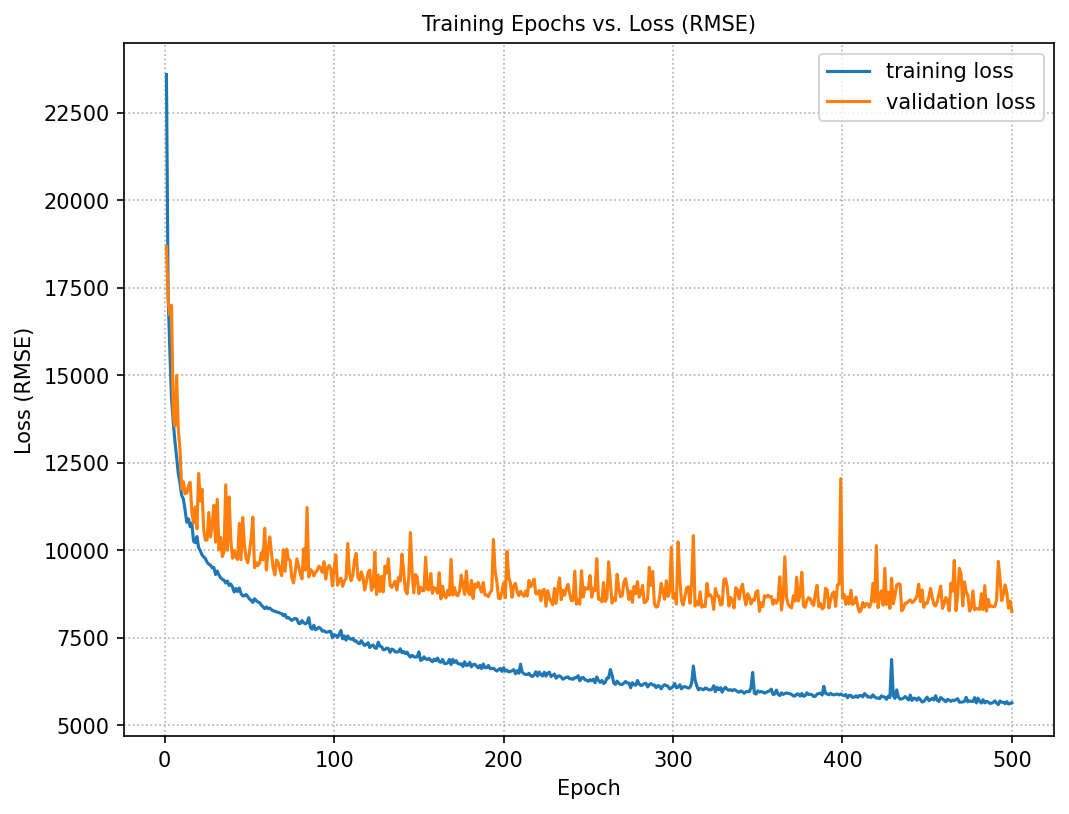

In [ ]:
import matplotlib.pyplot as plt


# prepare plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=150)

# plot the training epochs vs. the epochs classification error of the training and validation data set
ax.plot(np.array(range(1, len(train_epochs_loss)+1)), train_epochs_loss, label='training loss')
ax.plot(np.array(range(1, len(val_epochs_loss)+1)), val_epochs_loss, label='validation loss')

# add grid
ax.grid(linestyle='dotted')

# add axis legends
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss (RMSE)")

# add plot title
plt.title('Training Epochs vs. Loss (RMSE)', fontsize=10)

# add legend
plt.legend()

#show
plt.show()

## Evaluation des trainierten Modells

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt


# Bring Model in evaluation mode
model.eval()

# Init collection of all test losses
test_epoch_loss = 0

# List to store predictions and actual values for calculating RMSE
y_test_pred_nn = []
y_test_nn = []

y_val_pred_nn = []
y_val_nn = []

y_train_pred_nn = []
y_train_nn = []


y_kaggle_pred_nn = []
y_kaggle_nn = []


# Iterate over ONE test batch
for features, labels in test_dataloader:
    # Push test data to computation device
    features = features.float().to(device)
    labels = labels.view(-1, 1).float().to(device)


    # Run forward pass through the network
    output = model.forward(features)


    # Store predictions and actual values for calculating RMSE
    y_test_pred_nn.extend(output.detach().cpu().numpy())
    y_test_nn.extend(labels.detach().cpu().numpy())

    # Calculate RMSE
    rmse_test_nn = mean_squared_error(y_test_nn, y_test_pred_nn, squared=False)

    y_test_pred_nn = np.array(y_test_pred_nn)
    y_test_nn = np.array(y_test_nn)


# Iterate over ONE val batch
for features, labels in val_dataloader:
    # Push test data to computation device
    features = features.float().to(device)
    labels = labels.view(-1, 1).float().to(device)


    # Run forward pass through the network
    output = model.forward(features)


    # Store predictions and actual values for calculating RMSE
    y_val_pred_nn.extend(output.detach().cpu().numpy())
    y_val_nn.extend(labels.detach().cpu().numpy())

    # Calculate RMSE
    rmse_val_nn = mean_squared_error(y_val_nn, y_val_pred_nn, squared=False)

    y_val_pred_nn = np.array(y_val_pred_nn)
    y_val_nn = np.array(y_val_nn)



train_dataloader_1 = DataLoader(dataset_train, batch_size=len(X_train), shuffle=True)

# Iterate over One train batch
for features, labels in train_dataloader_1:
    # Push mini-batch data to computation device
    features = features.float().to(device)
    labels = labels.view(-1, 1).float().to(device)


    # Run forward pass through the network
    output = model.forward(features)


    # Store predictions and actual values for calculating RMSE
    y_train_pred_nn.extend(output.detach().cpu().numpy())
    y_train_nn.extend(labels.detach().cpu().numpy())

    # Calculate RMSE
    rmse_train_nn = mean_squared_error(y_train_nn, y_train_pred_nn, squared=False)

    y_train_pred_nn = np.array(y_train_pred_nn)
    y_train_nn = np.array(y_train_nn)



# Print the RMSE
print(f"RMSE Train: {rmse_train_nn}\nRMSE Val: {rmse_val_nn}\nRMSE Test: {rmse_test_nn}")

RMSE Train: 5357.02490234375
RMSE Val: 8247.0947265625
RMSE Test: 9541.8349609375


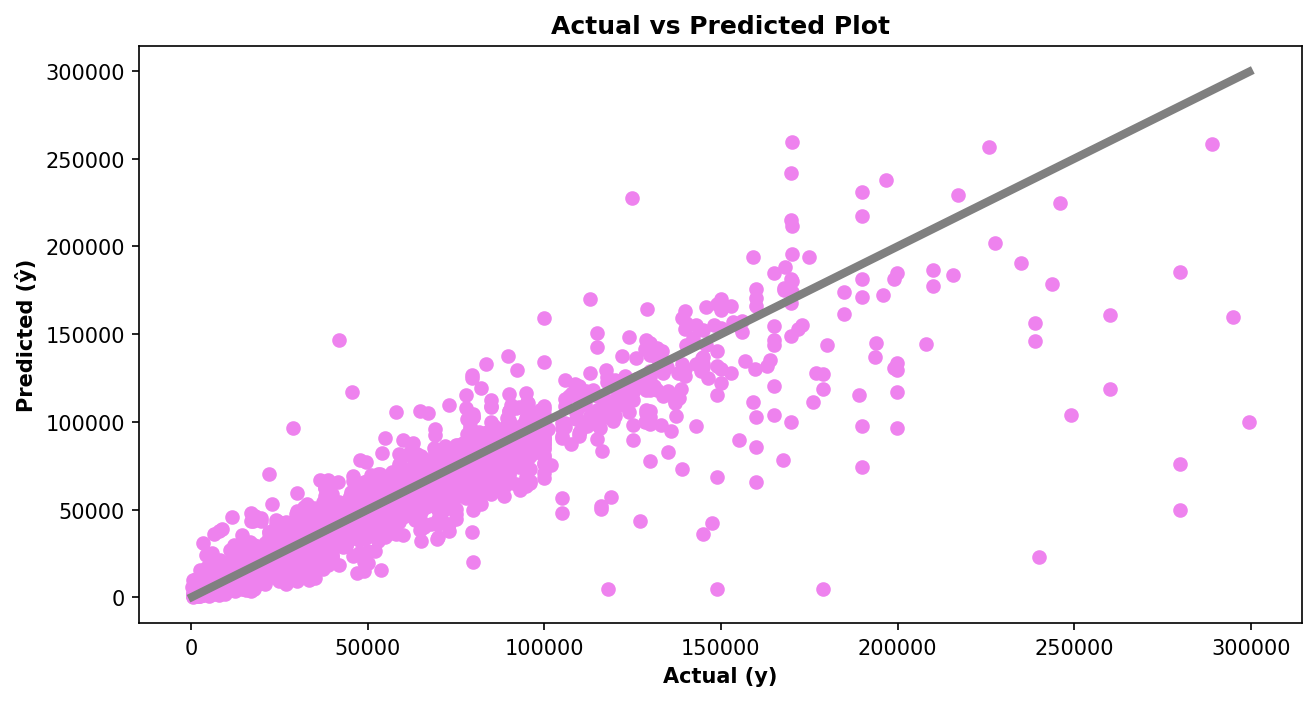

In [63]:
import numpy as np
import matplotlib.pyplot as plt


min_value = np.array([y_test_nn.min(), y_test_pred_nn.min()]).min()
max_value = np.array([y_test_nn.max(), y_test_pred_nn.max()]).max()

fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
ax.scatter(y_test_nn, y_test_pred_nn, color="violet")
ax.plot([min_value, max_value], [min_value, max_value], lw=4, color="grey")



ax.set_title("Actual vs Predicted Plot", fontweight="bold")
ax.set_xlabel('Actual (y)', fontweight="bold")
ax.set_ylabel('Predicted (ŷ)', fontweight="bold")

plt.show()

In [73]:
# Read in the data
cars_explorer = pd.read_csv("/content/drive/MyDrive/Cars_Data_Explorer.csv", sep=";", index_col=0)
# Behalte nur Samples mit einem Preis kleiner als 300,000 --> Ausreisser entfernen
cars_explorer = cars_explorer[cars_explorer["Preis"] < 300000]

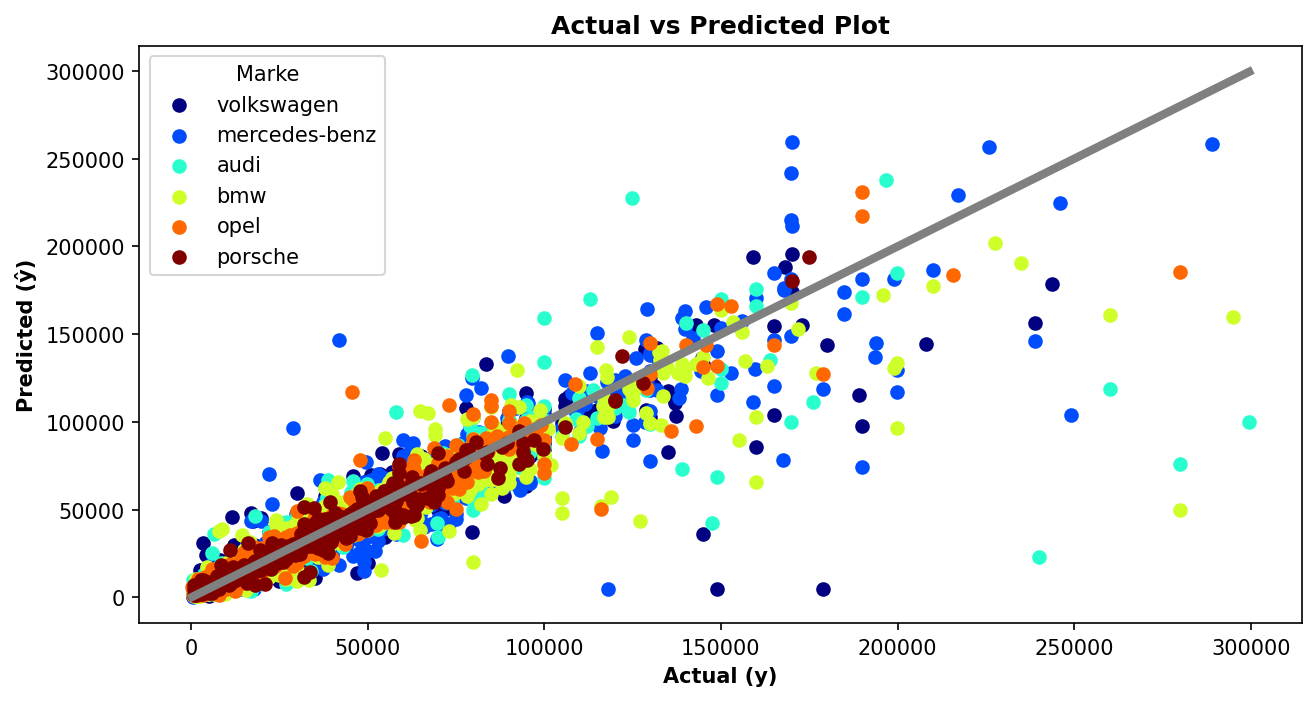

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Angenommen, dies sind Ihre Daten
# y_test_nn, y_test_pred_nn, und der cars_explorer DataFrame

# Umwandlung von y_test_nn und y_test_pred_nn in Pandas Series
y_test_nn_series = pd.Series(y_test_nn.flatten(), index=y_test.index)
y_test_pred_nn_series = pd.Series(y_test_pred_nn.flatten(), index=y_test.index)

# Erstellen einer Farbkarte für die Automarken
unique_brands = cars_explorer['Marke'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(unique_brands)))
brand_to_color = dict(zip(unique_brands, colors))

# Berechnen von min_value und max_value für die Linie y=x
min_value = np.array([y_test_nn_series.min(), y_test_pred_nn_series.min()]).min()
max_value = np.array([y_test_nn_series.max(), y_test_pred_nn_series.max()]).max()

# Erstellen des Plots
fig, ax = plt.subplots(figsize=(10, 5), dpi=150)

# Plotten jedes Punkts mit der Farbe seiner Marke
for brand in unique_brands:
    # Finde die Indizes für die aktuelle Marke in cars_explorer
    brand_indices = cars_explorer[cars_explorer['Marke'] == brand].index

    # Behalte nur die Indizes, die sowohl in brand_indices als auch in y_test_nn_series vorhanden sind
    common_indices = y_test_nn_series.index.intersection(brand_indices)

    # Plotten der Punkte für diese Marke
    if not common_indices.empty:
        ax.scatter(y_test_nn_series[common_indices], y_test_pred_nn_series[common_indices], color=brand_to_color[brand], label=brand)

# Linie y=x
ax.plot([min_value, max_value], [min_value, max_value], lw=4, color="grey")

# Titel und Achsenbeschriftungen
ax.set_title("Actual vs Predicted Plot", fontweight="bold")
ax.set_xlabel('Actual (y)', fontweight="bold")
ax.set_ylabel('Predicted (ŷ)', fontweight="bold")

# Legende hinzufügen
ax.legend(title="Marke")

plt.show()
